<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Stock_Price_anomaly_detection_Using_Stupid_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!nvidia-smi

In [ ]:
#!pip install gdown
#!pip install tensorflow-gpu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20, 15

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
#!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

In [ ]:
ticker = '^NSEI'
#!pip install yfinance --upgrade --no-cache-dir
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
START = "2007-01-01"  #yyyy-mm-dd
df = pdr.get_data_yahoo(ticker, start=START)
df = df.dropna()
#df = df.iloc[:,:4]
#df = df.resample('W').close()
df.head(3)
data = df.copy()

[*********************100%***********************]  1 of 1 downloaded


In [ ]:
#df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [ ]:
df = df[['Close']]
#df.head()

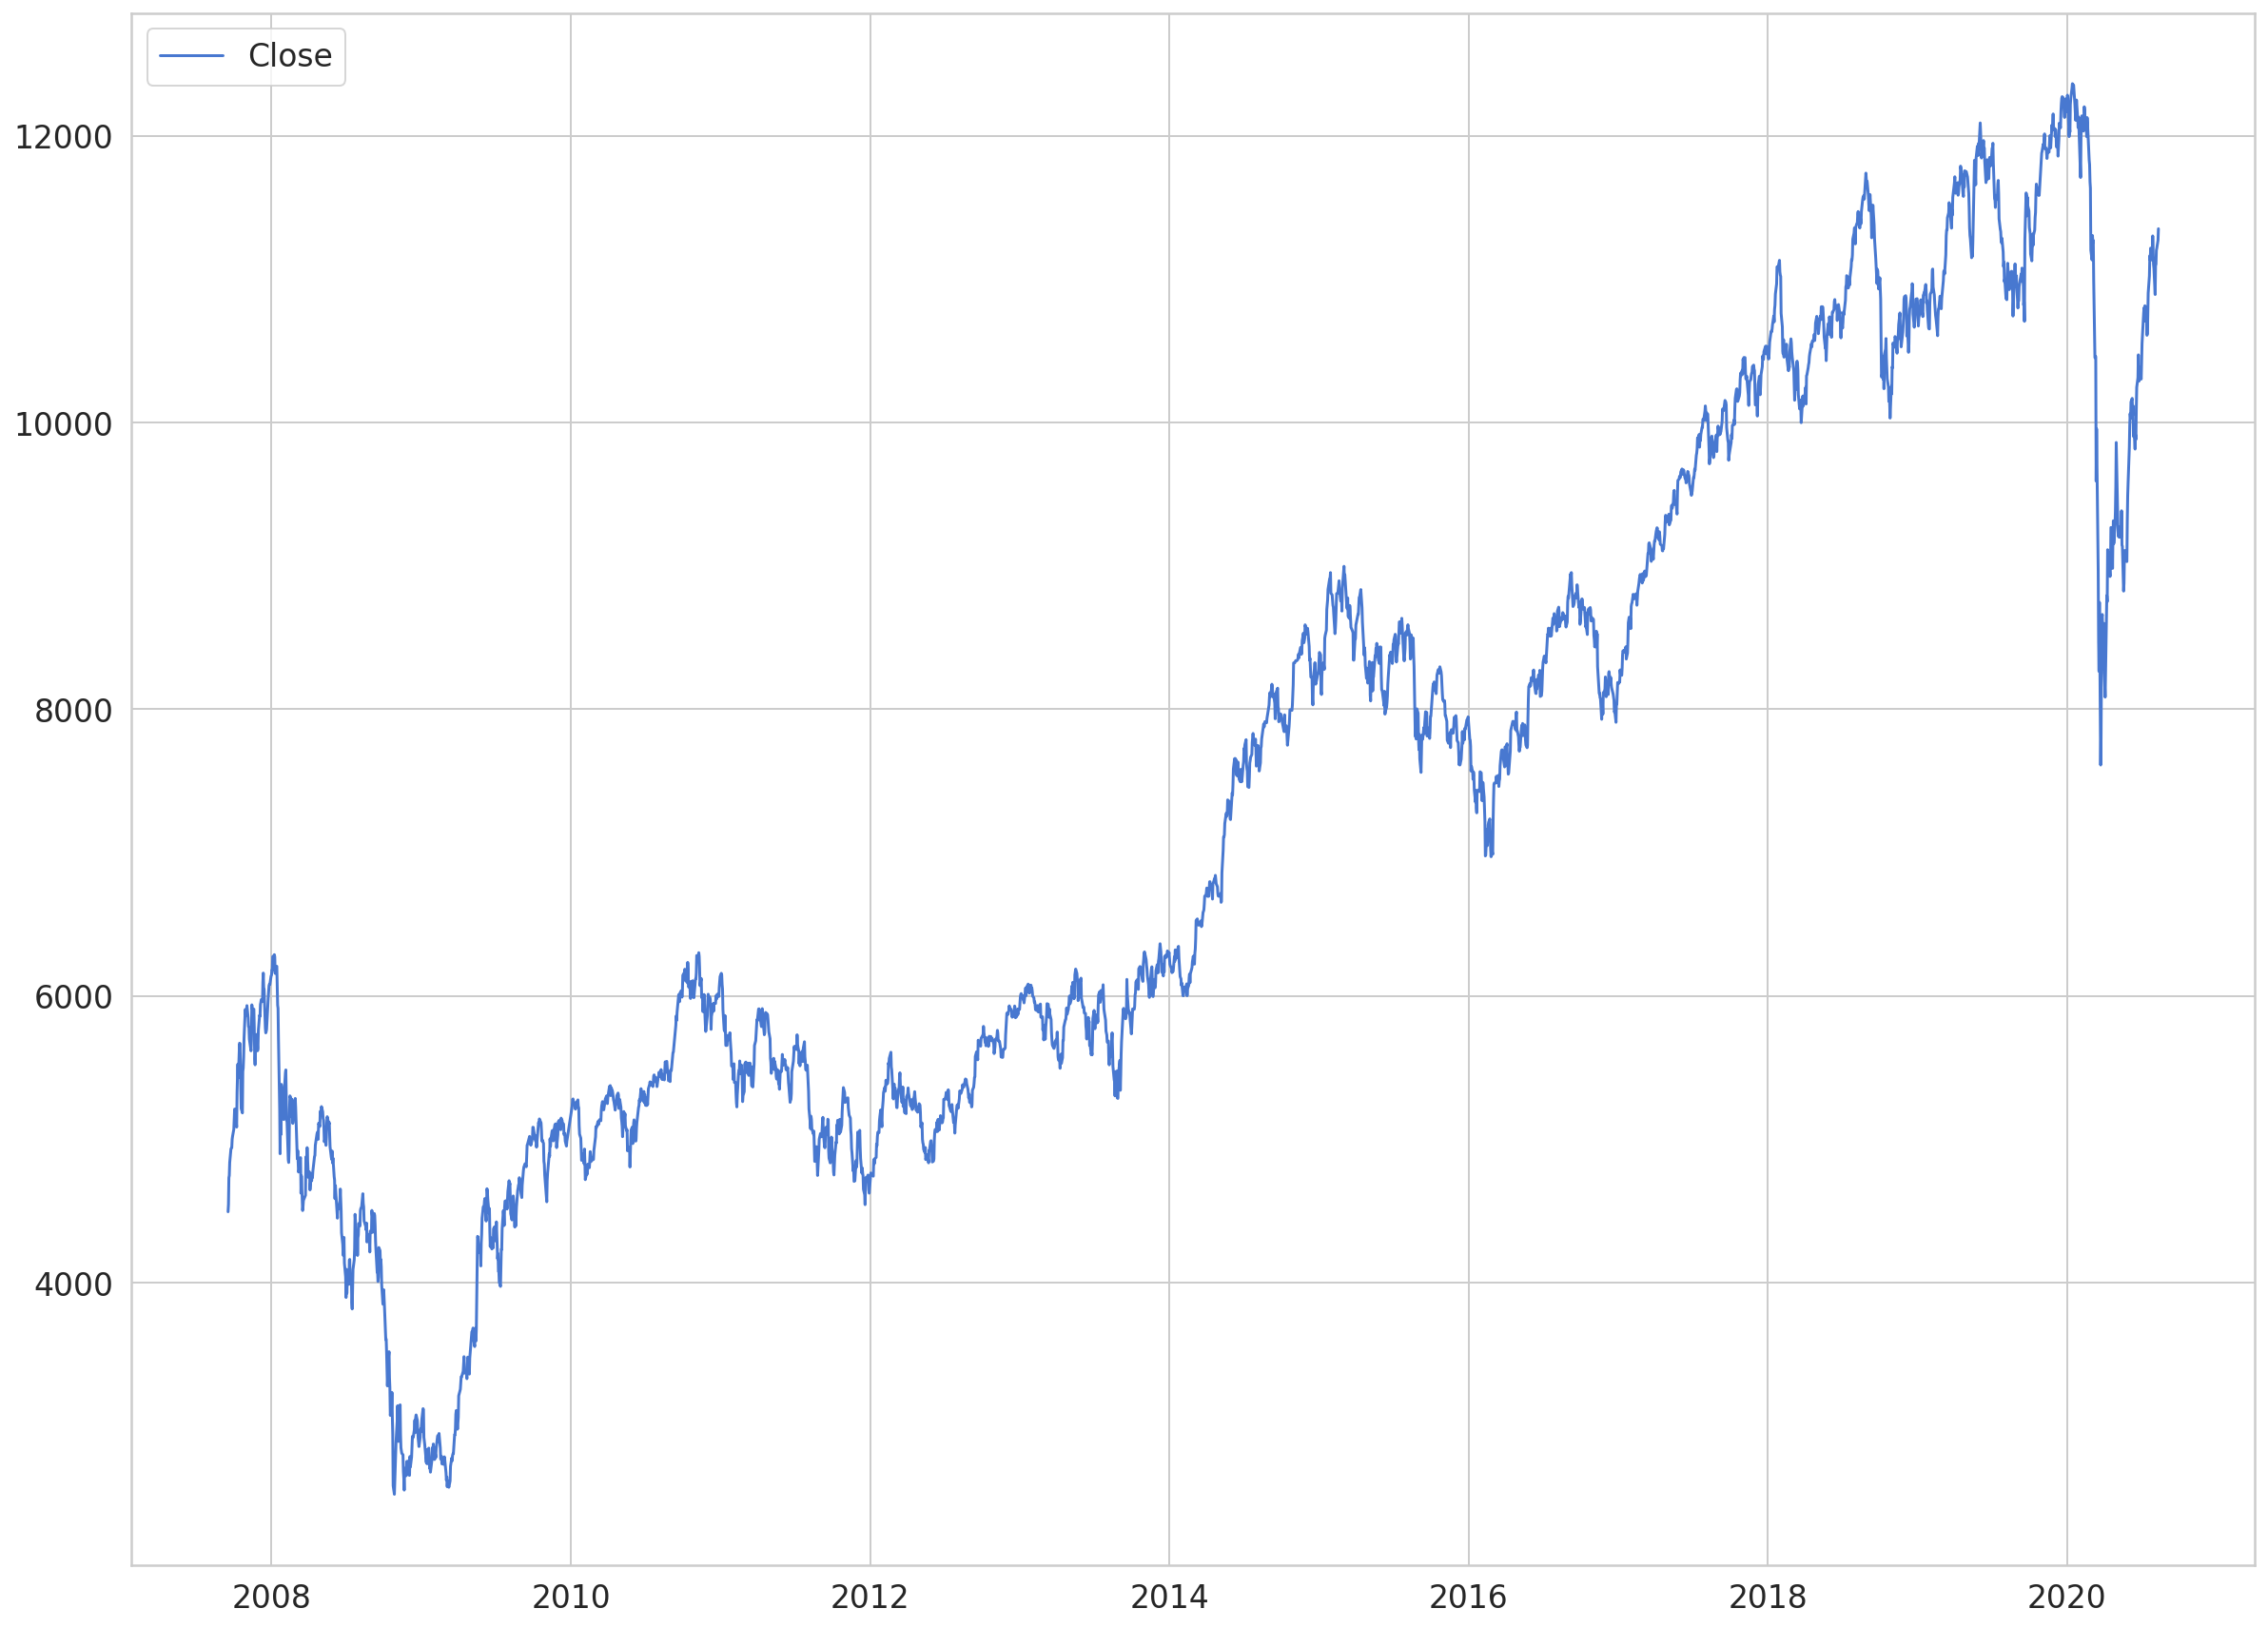

In [ ]:
plt.plot(df, label='Close')
plt.legend();

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(2520, 1) (630, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Close']], train.Close, TIME_STEPS)
X_test, y_test = create_dataset(test[['Close']], test.Close, TIME_STEPS)

print(X_train.shape)

(2510, 10, 1)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
71/71 [==============================] - 2s 22ms/step - loss: 0.2870 - val_loss: 0.5120
Epoch 2/10
71/71 [==============================] - 1s 12ms/step - loss: 0.2007 - val_loss: 0.2398
Epoch 3/10
71/71 [==============================] - 1s 12ms/step - loss: 0.1309 - val_loss: 0.1325
Epoch 4/10
71/71 [==============================] - 1s 12ms/step - loss: 0.1641 - val_loss: 0.1414
Epoch 5/10
71/71 [==============================] - 1s 12ms/step - loss: 0.1263 - val_loss: 0.1309
Epoch 6/10
71/71 [==============================] - 1s 12ms/step - loss: 0.1262 - val_loss: 0.1476
Epoch 7/10
71/71 [==============================] - 1s 12ms/step - loss: 0.1145 - val_loss: 0.0789
Epoch 8/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0885 - val_loss: 0.0578
Epoch 9/10
71/71 [==============================] - 1s 12ms/step - loss: 0.0919 - val_loss: 0.0514
Epoch 10/10
71/71 [==============================] - 1s 13ms/step - loss: 0.1109 - val_loss: 0.0521


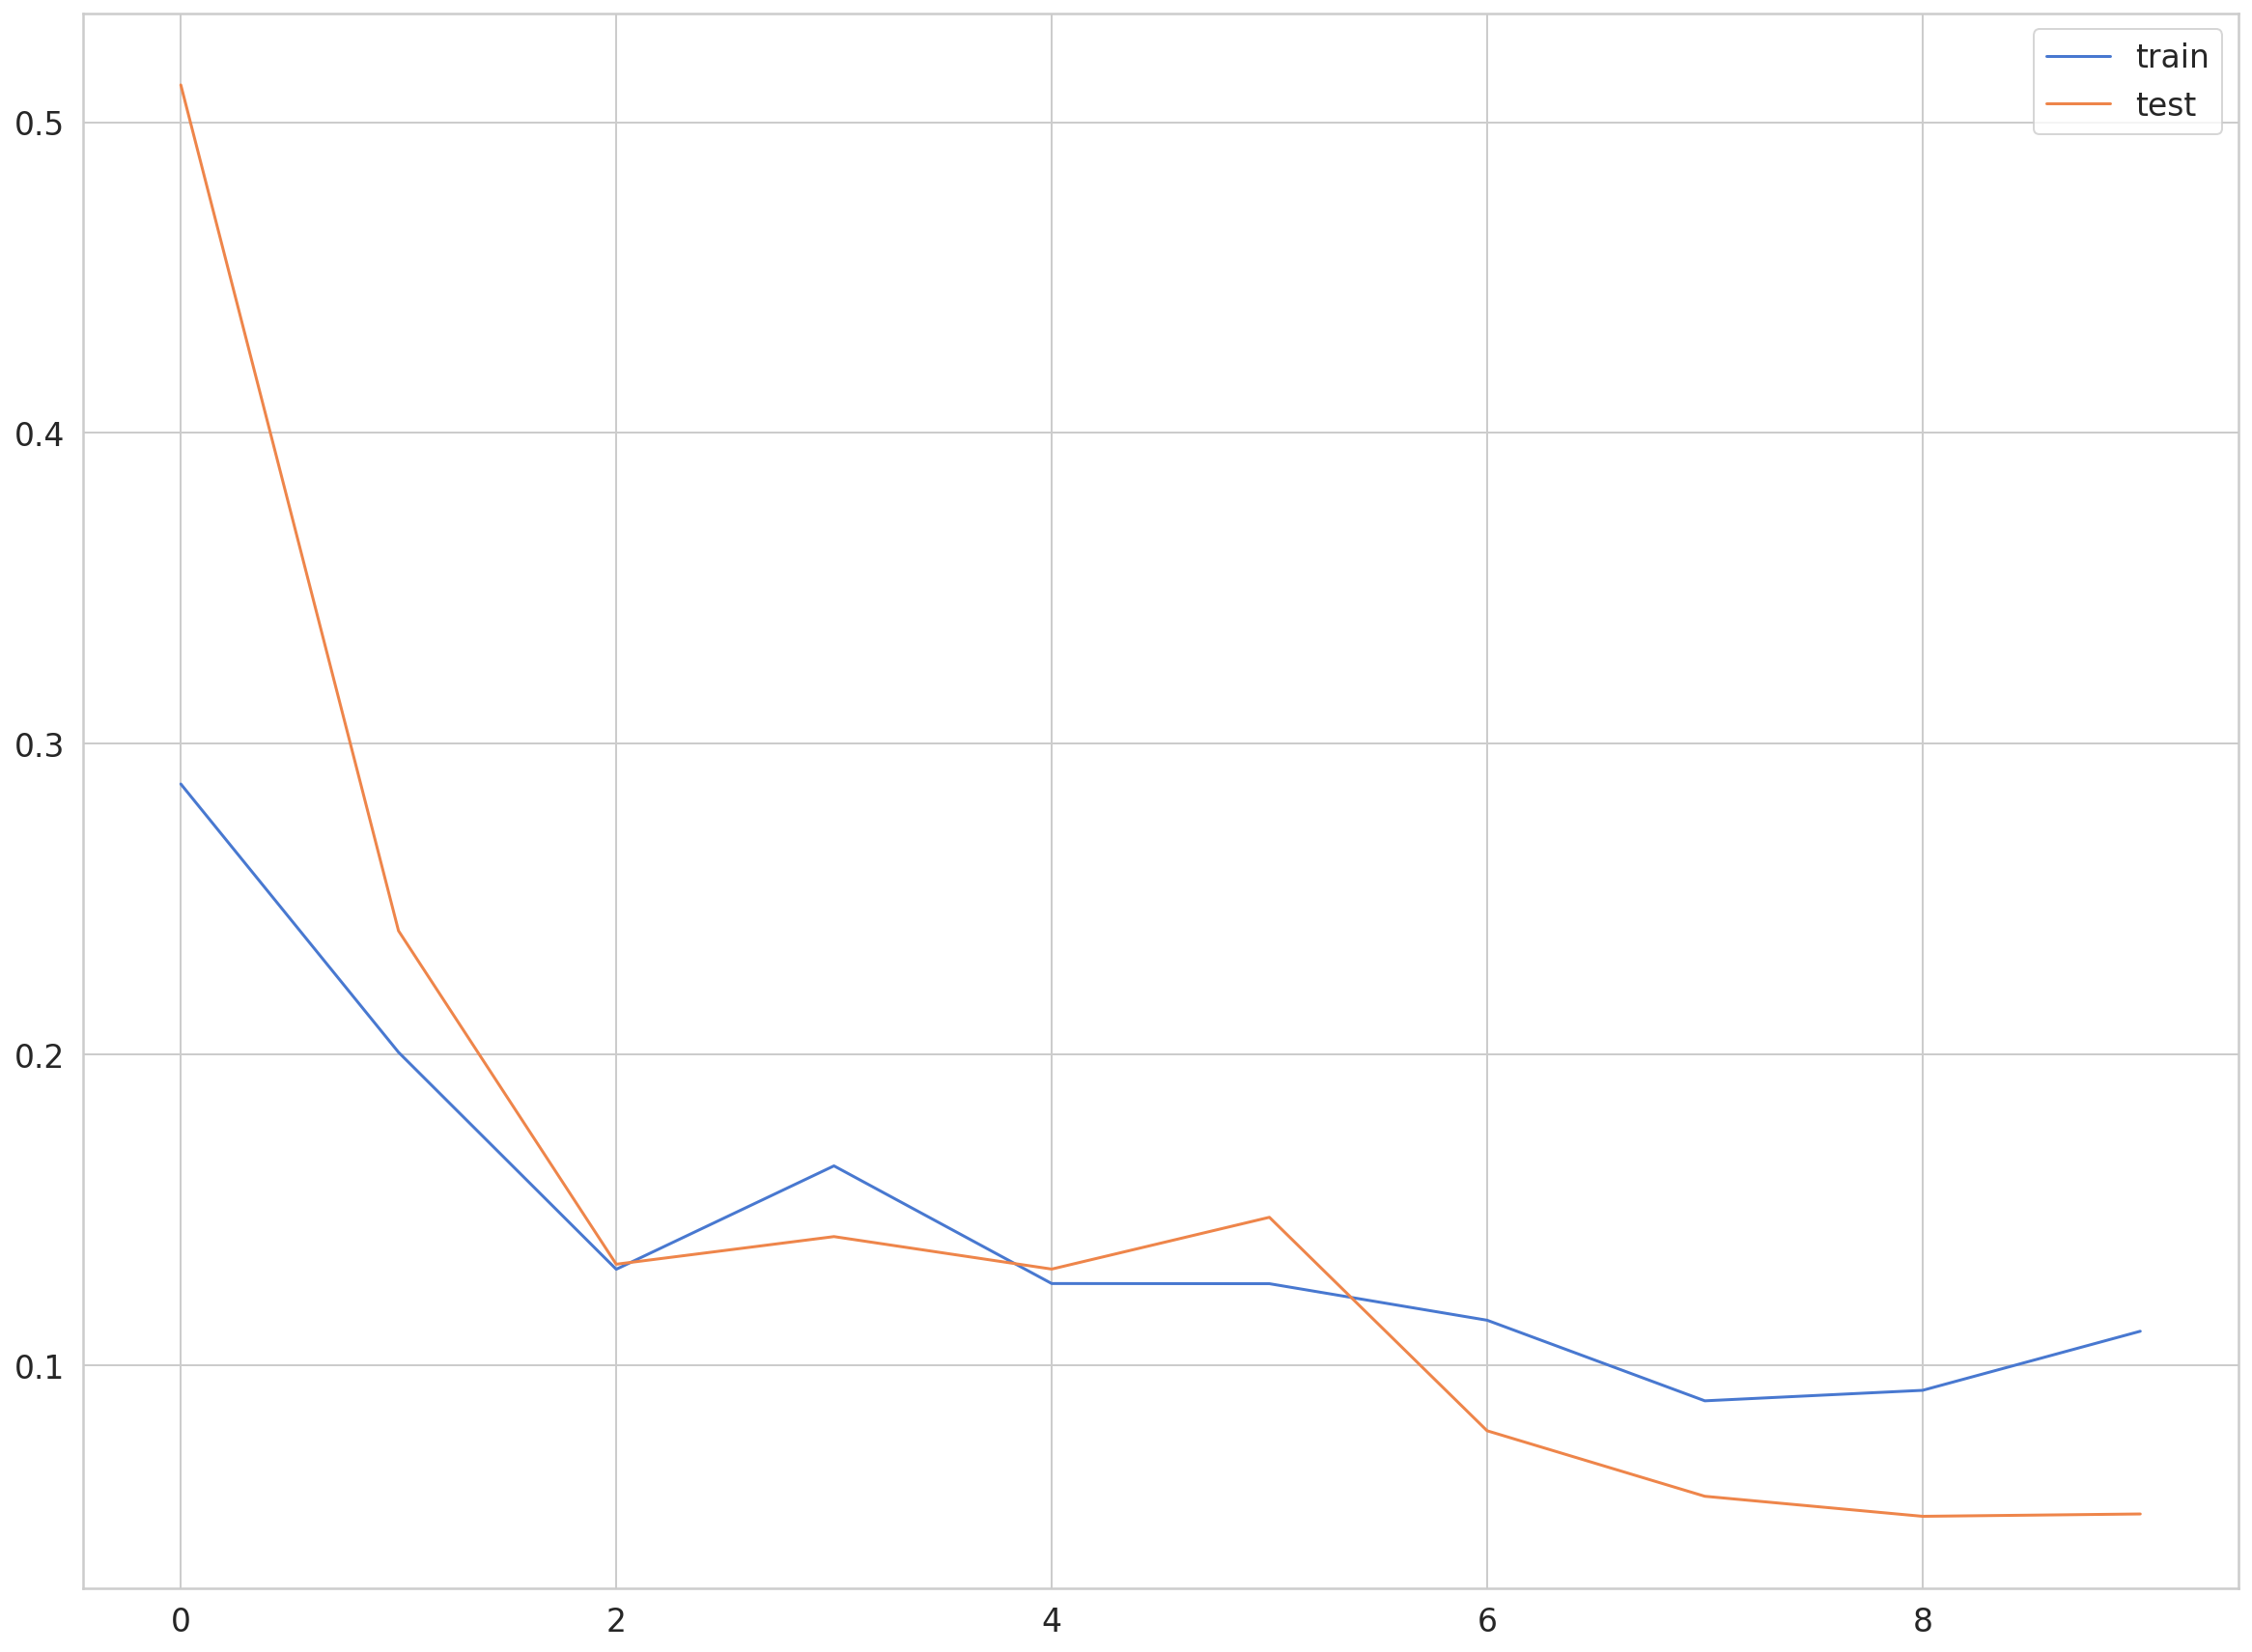

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

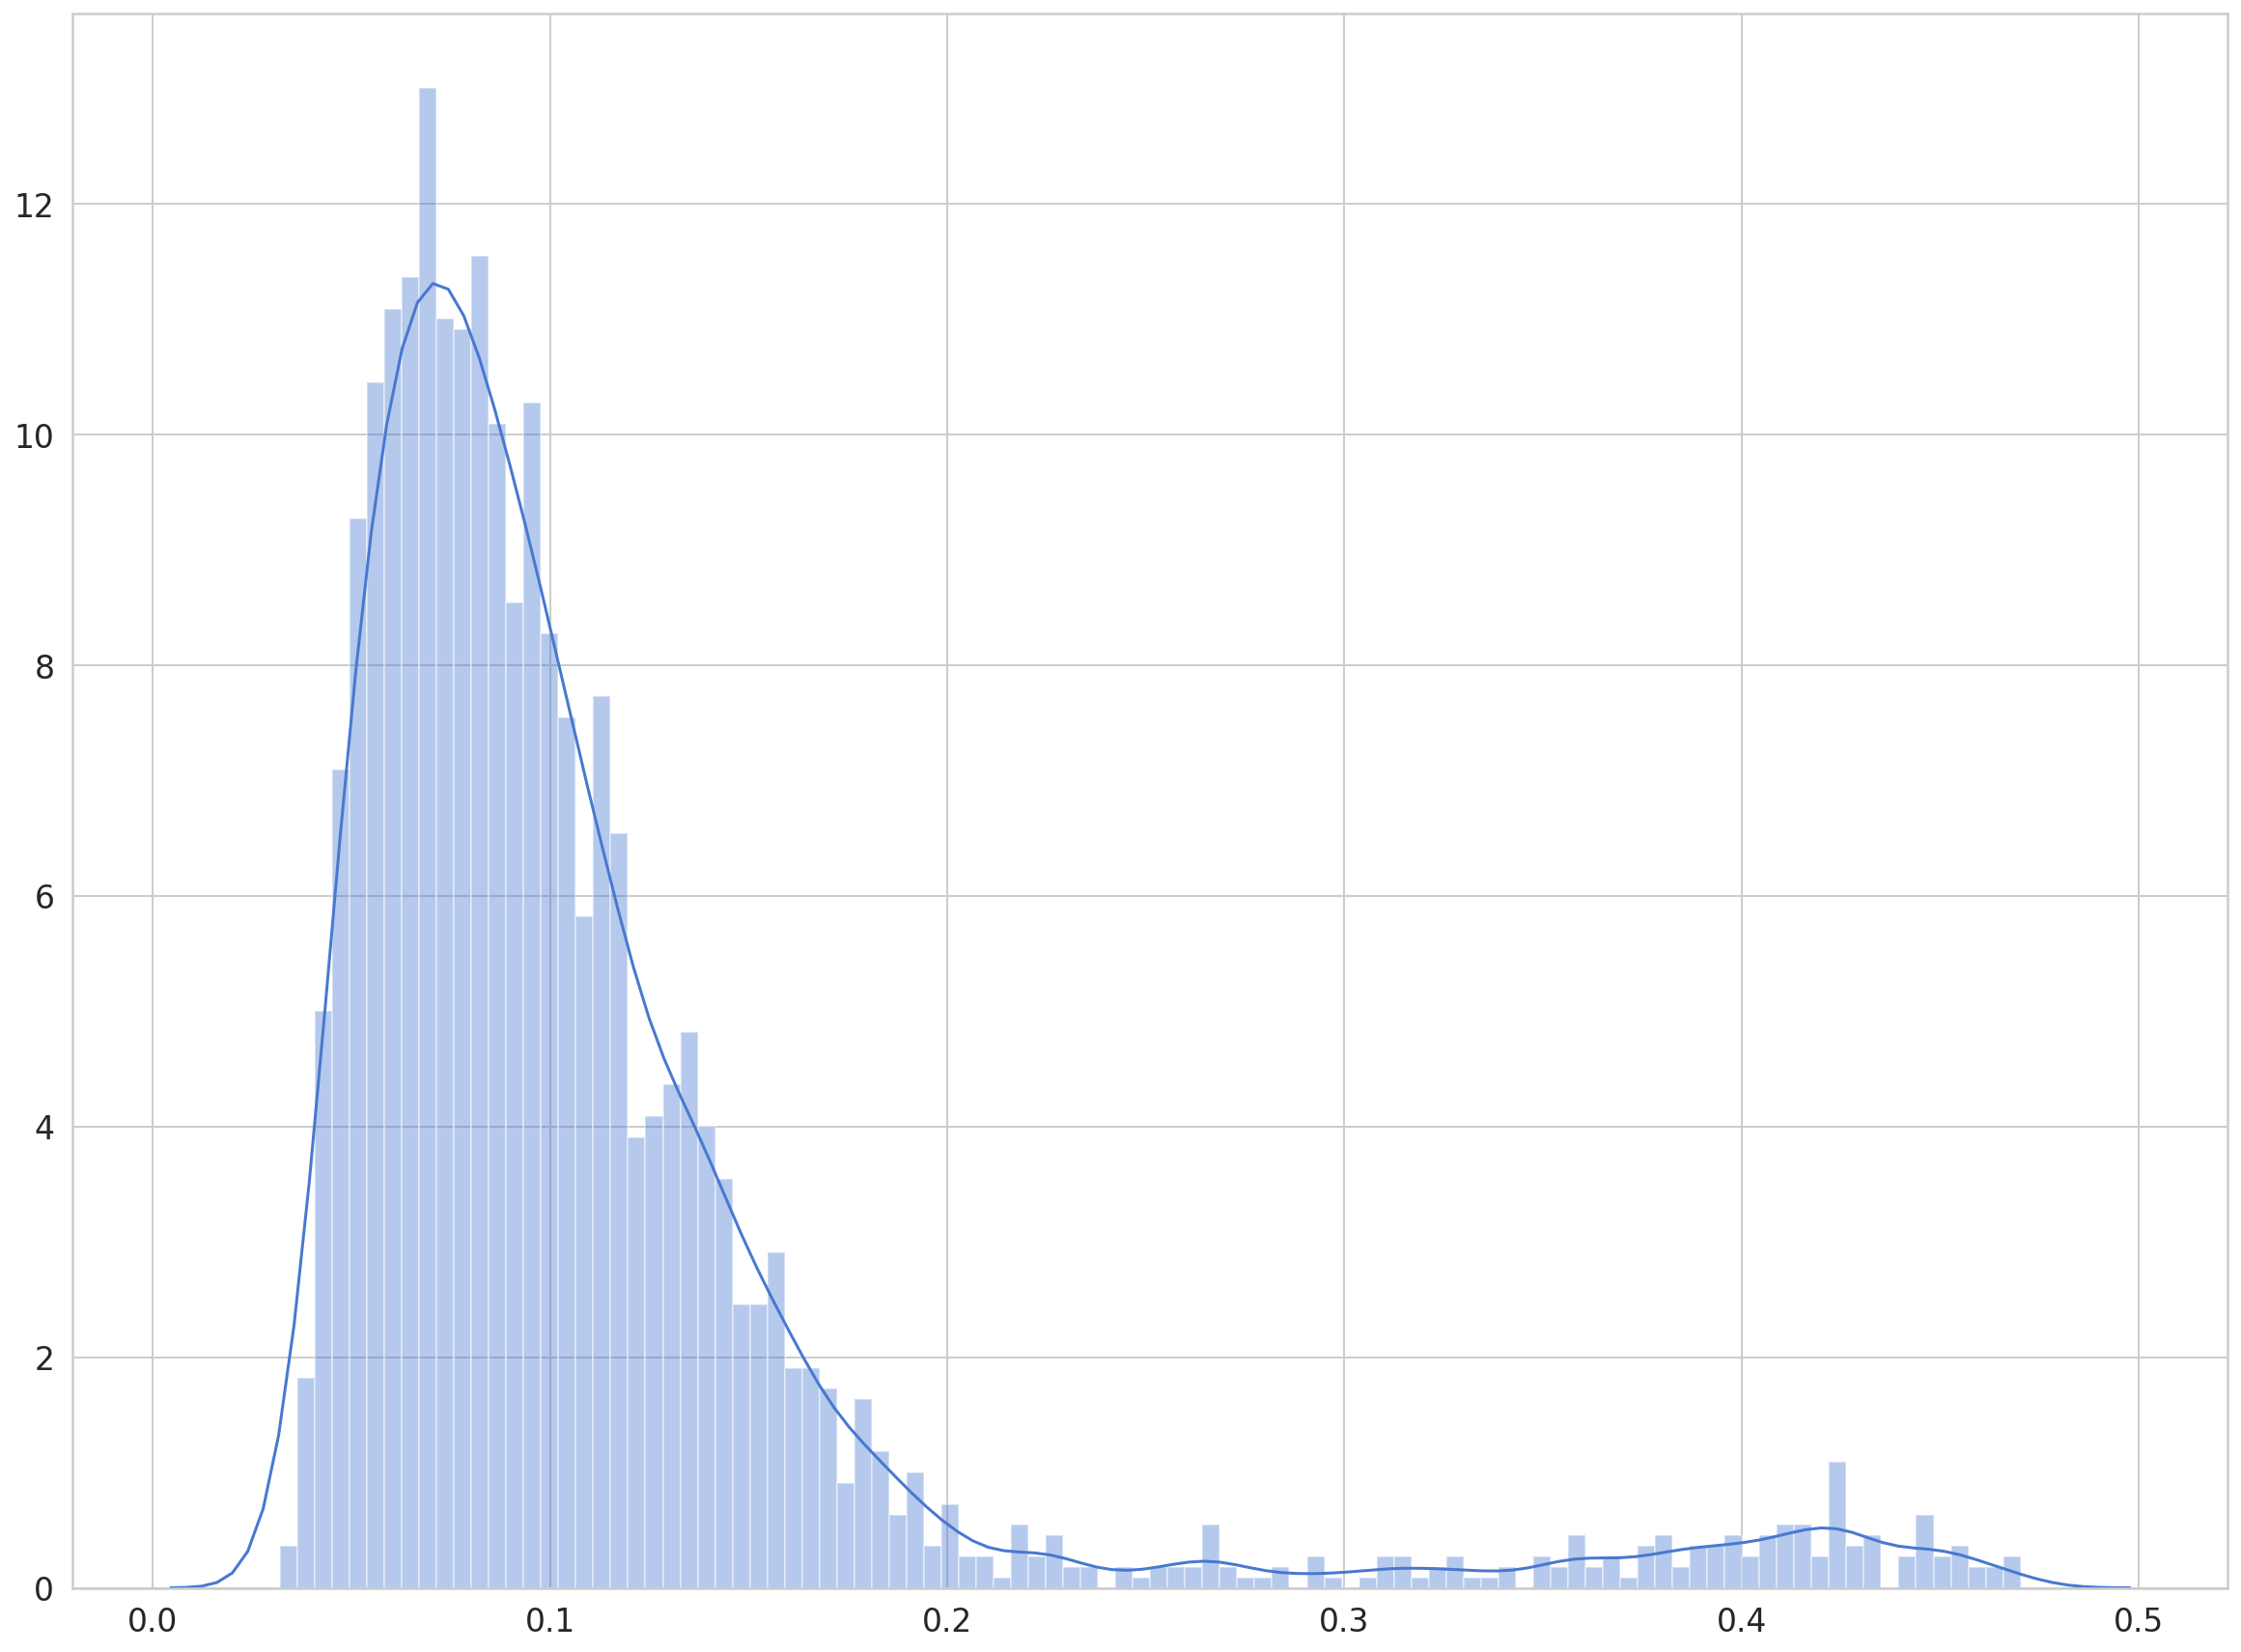

In [ ]:
sns.distplot(train_mae_loss, bins=100, kde=True);

In [ ]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [ ]:

THRESHOLDSHORT = .08  # CHANGE THIS

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['thresholdSHORT'] = THRESHOLDSHORT
test_score_df['anomalySHORT'] = test_score_df.loss < test_score_df.thresholdSHORT 
test_score_df['Close'] = test[TIME_STEPS:].Close

In [ ]:
test_score_df.head(2)

,loss,thresholdSHORT,anomalySHORT,Close
Date,,,,
2018-01-29,0.083692,0.08,False,2.595573
2018-01-30,0.079386,0.08,True,2.551431


In [ ]:
THRESHOLDLONG = .2 # CHANGE THIS

#test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['thresholdLONG'] = THRESHOLDLONG
test_score_df['anomalyLONG'] = test_score_df.loss > test_score_df.thresholdLONG  
test_score_df['Close'] = test[TIME_STEPS:].Close

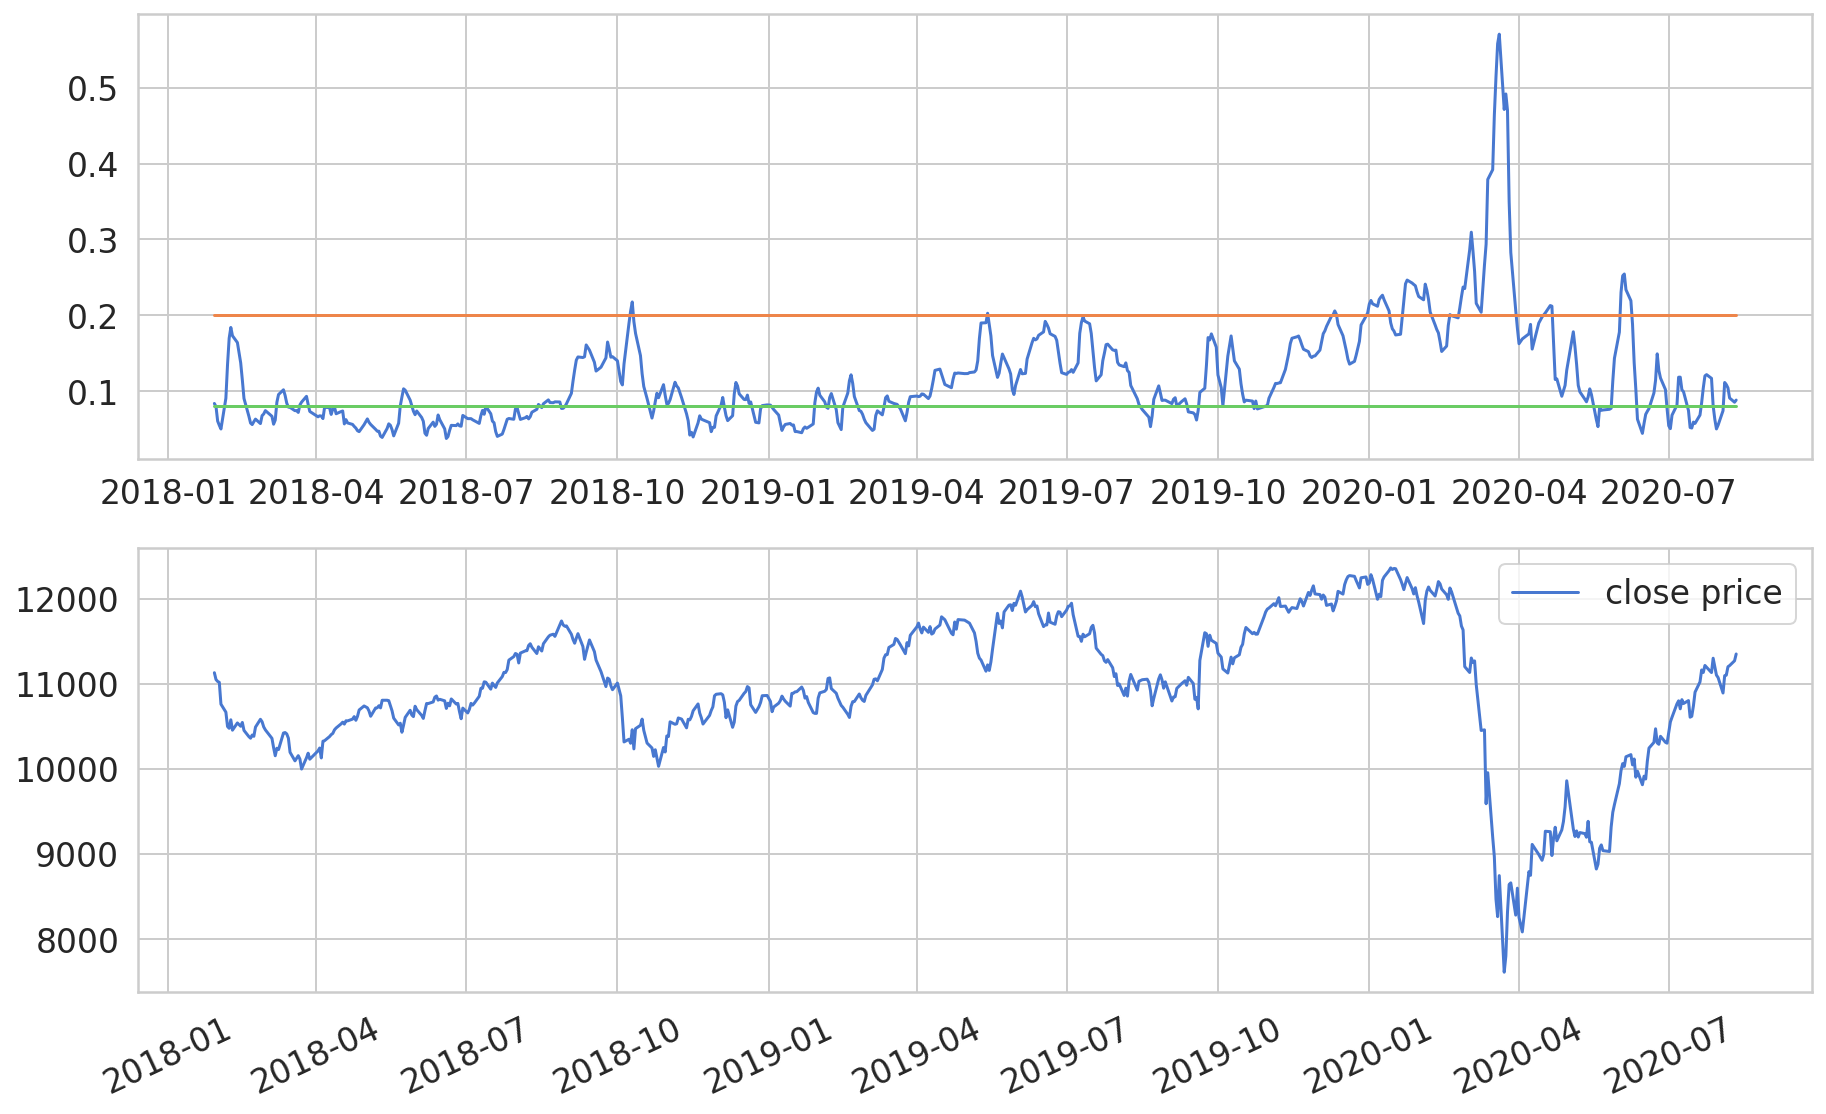

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(15,9))
ax[0].plot(test_score_df.index, test_score_df.loss, label='loss')
ax[0].plot(test_score_df.index, test_score_df.thresholdLONG, label='thresholdLONG')
ax[0].plot(test_score_df.index, test_score_df.thresholdSHORT, label='thresholdSHORT')
ax[1].plot(test[TIME_STEPS:].index,scaler.inverse_transform(test[TIME_STEPS:].Close),label='close price')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
temp = test_score_df[['loss','thresholdLONG','Close','anomalyLONG']]
anomaliesL = temp[temp.anomalyLONG == True]
anomaliesL.tail()

,loss,thresholdLONG,Close,anomalyLONG
Date,,,,
2020-06-02,0.230180,0.2,1.966219,True
2020-06-03,0.252015,0.2,2.011290,True
2020-06-04,0.254460,0.2,1.993551,True
2020-06-05,0.233724,0.2,2.055350,True
2020-06-08,0.219235,0.2,2.069180,True


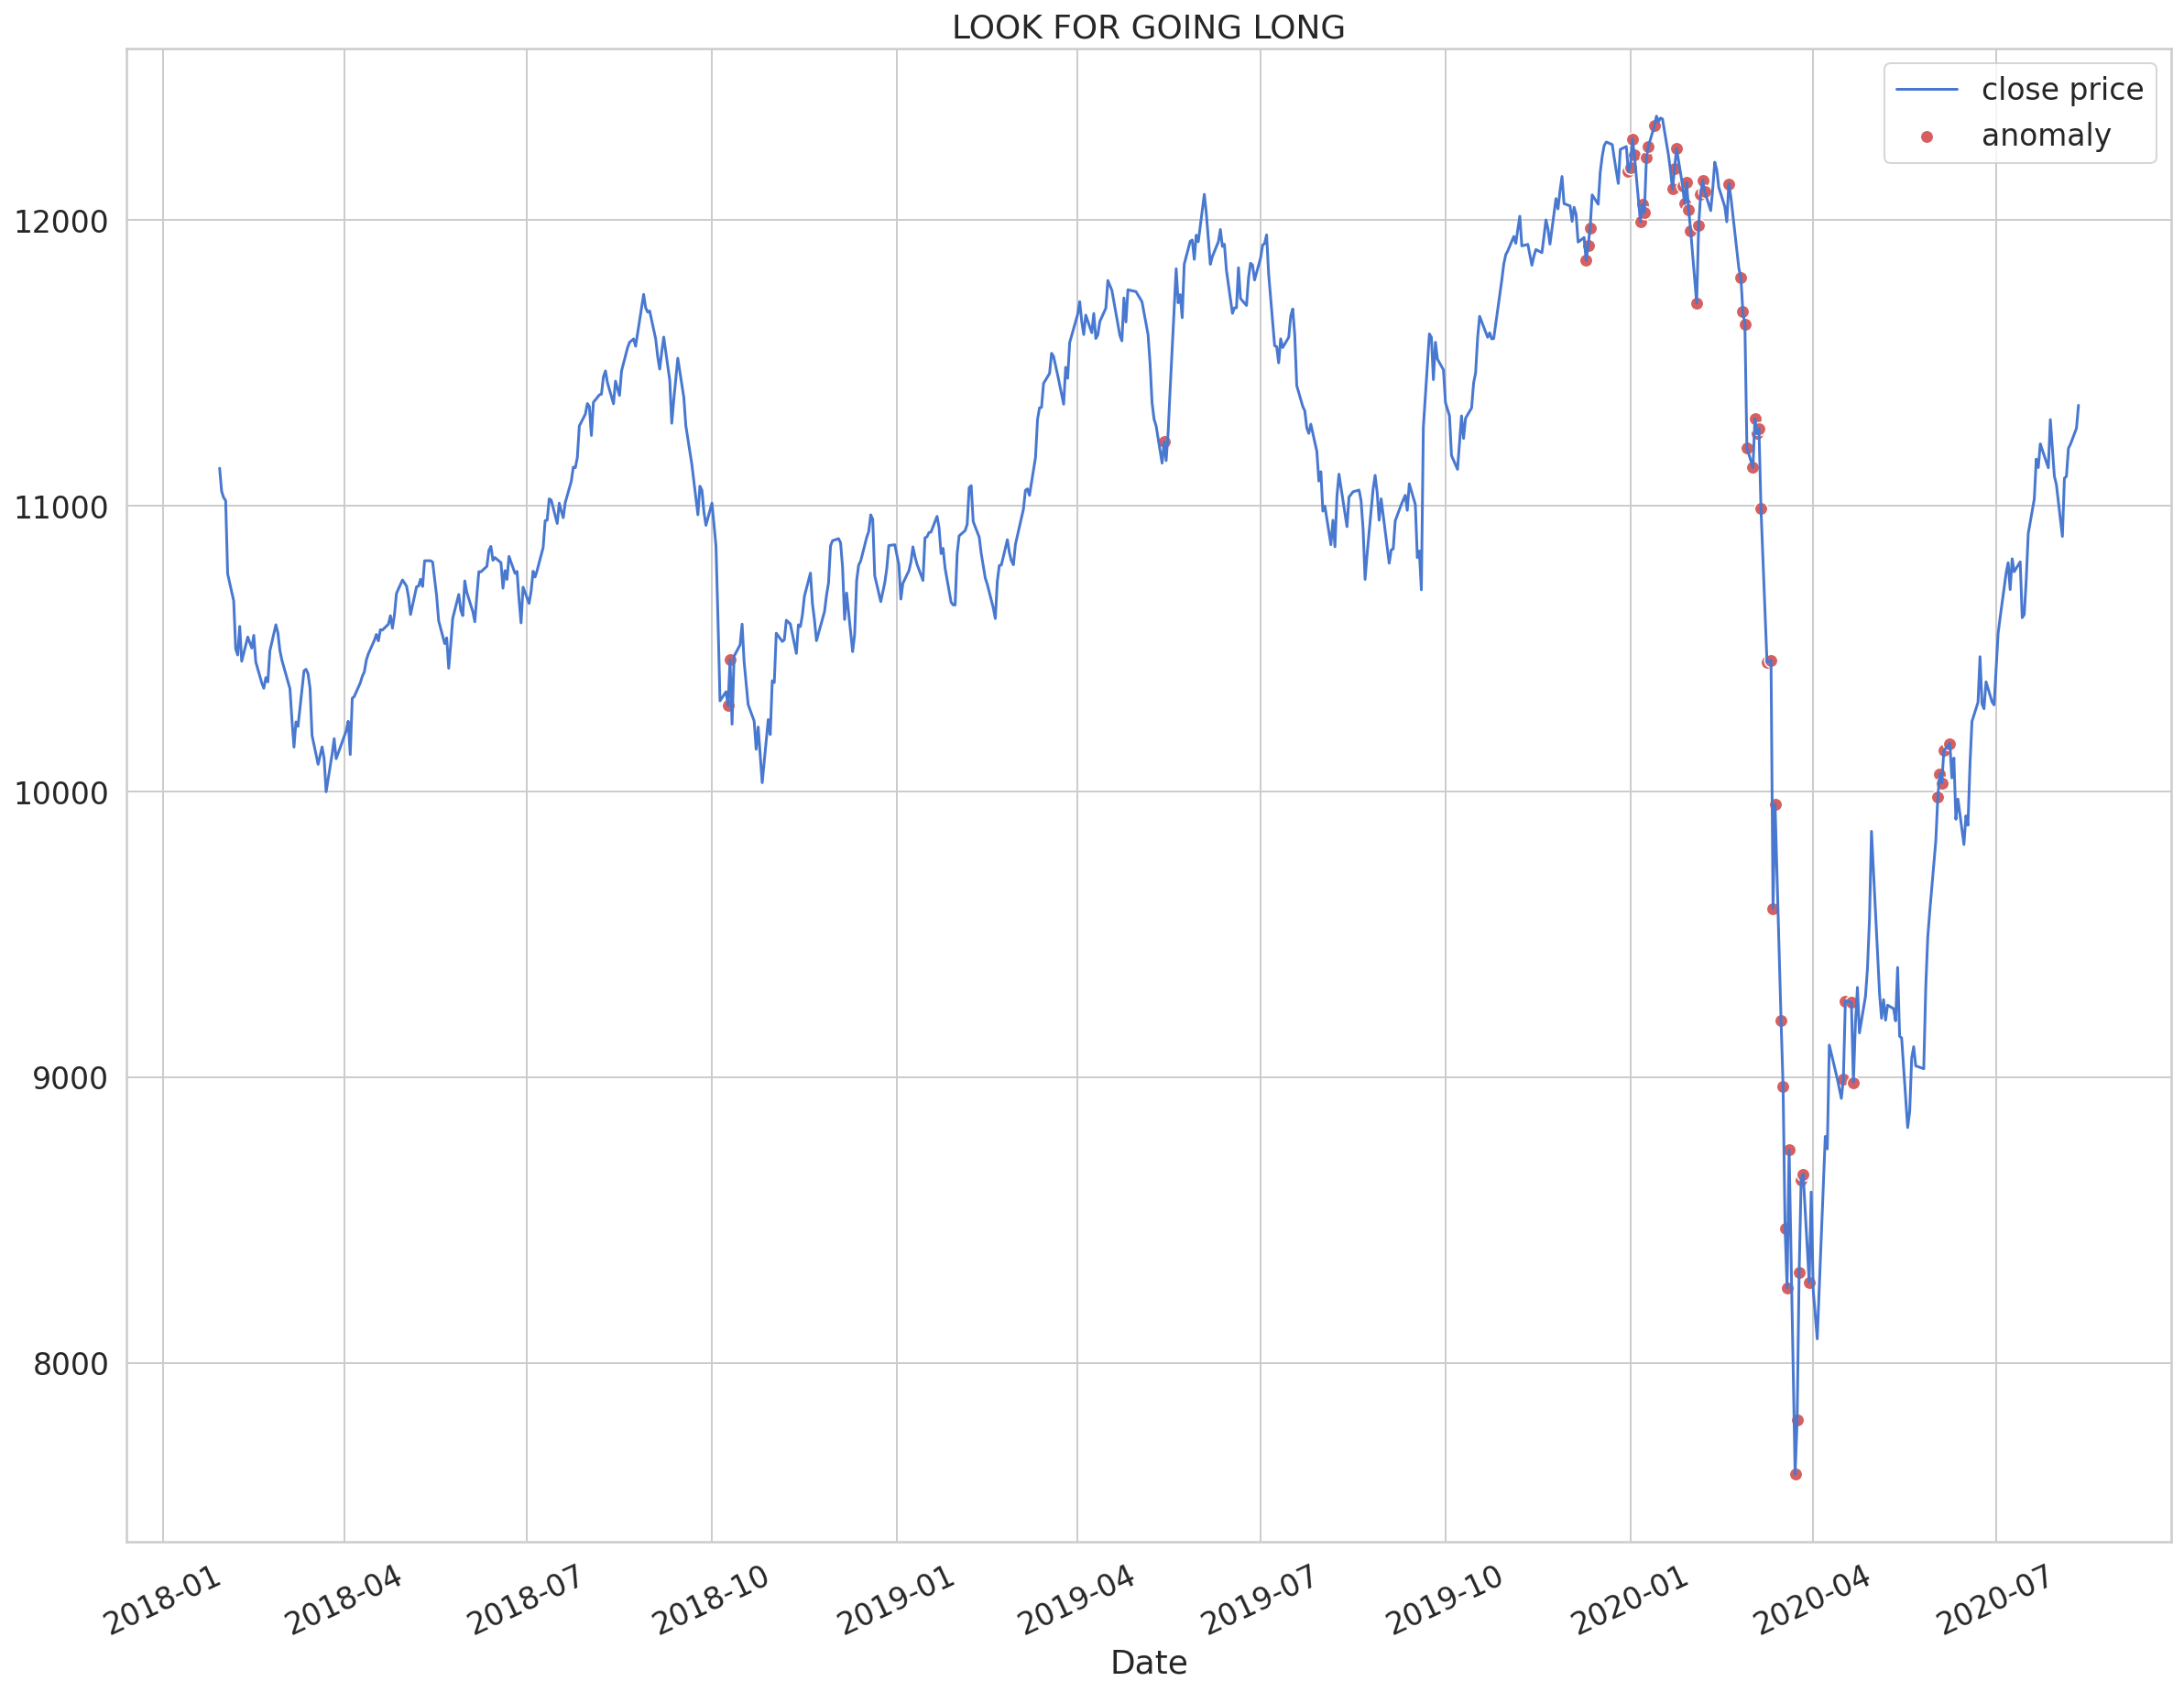

In [ ]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].Close), 
  label='close price'
);

sns.scatterplot(
  anomaliesL.index,
  scaler.inverse_transform(anomaliesL.Close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.savefig('anamolyLONG.png', dpi=150)
plt.title('LOOK FOR GOING LONG')
plt.legend();

In [ ]:
temp_1 = test_score_df[['loss','thresholdSHORT','Close','anomalySHORT']]
anomaliesS = temp_1[temp_1.anomalySHORT == True]
anomaliesS.head()

,loss,thresholdSHORT,Close,anomalySHORT
Date,,,,
2018-01-30,0.079386,0.08,2.551431,True
2018-01-31,0.060379,0.08,2.539432,True
2018-02-01,0.054877,0.08,2.533528,True
2018-02-02,0.049998,0.08,2.393423,True
2018-02-19,0.066688,0.08,2.184495,True


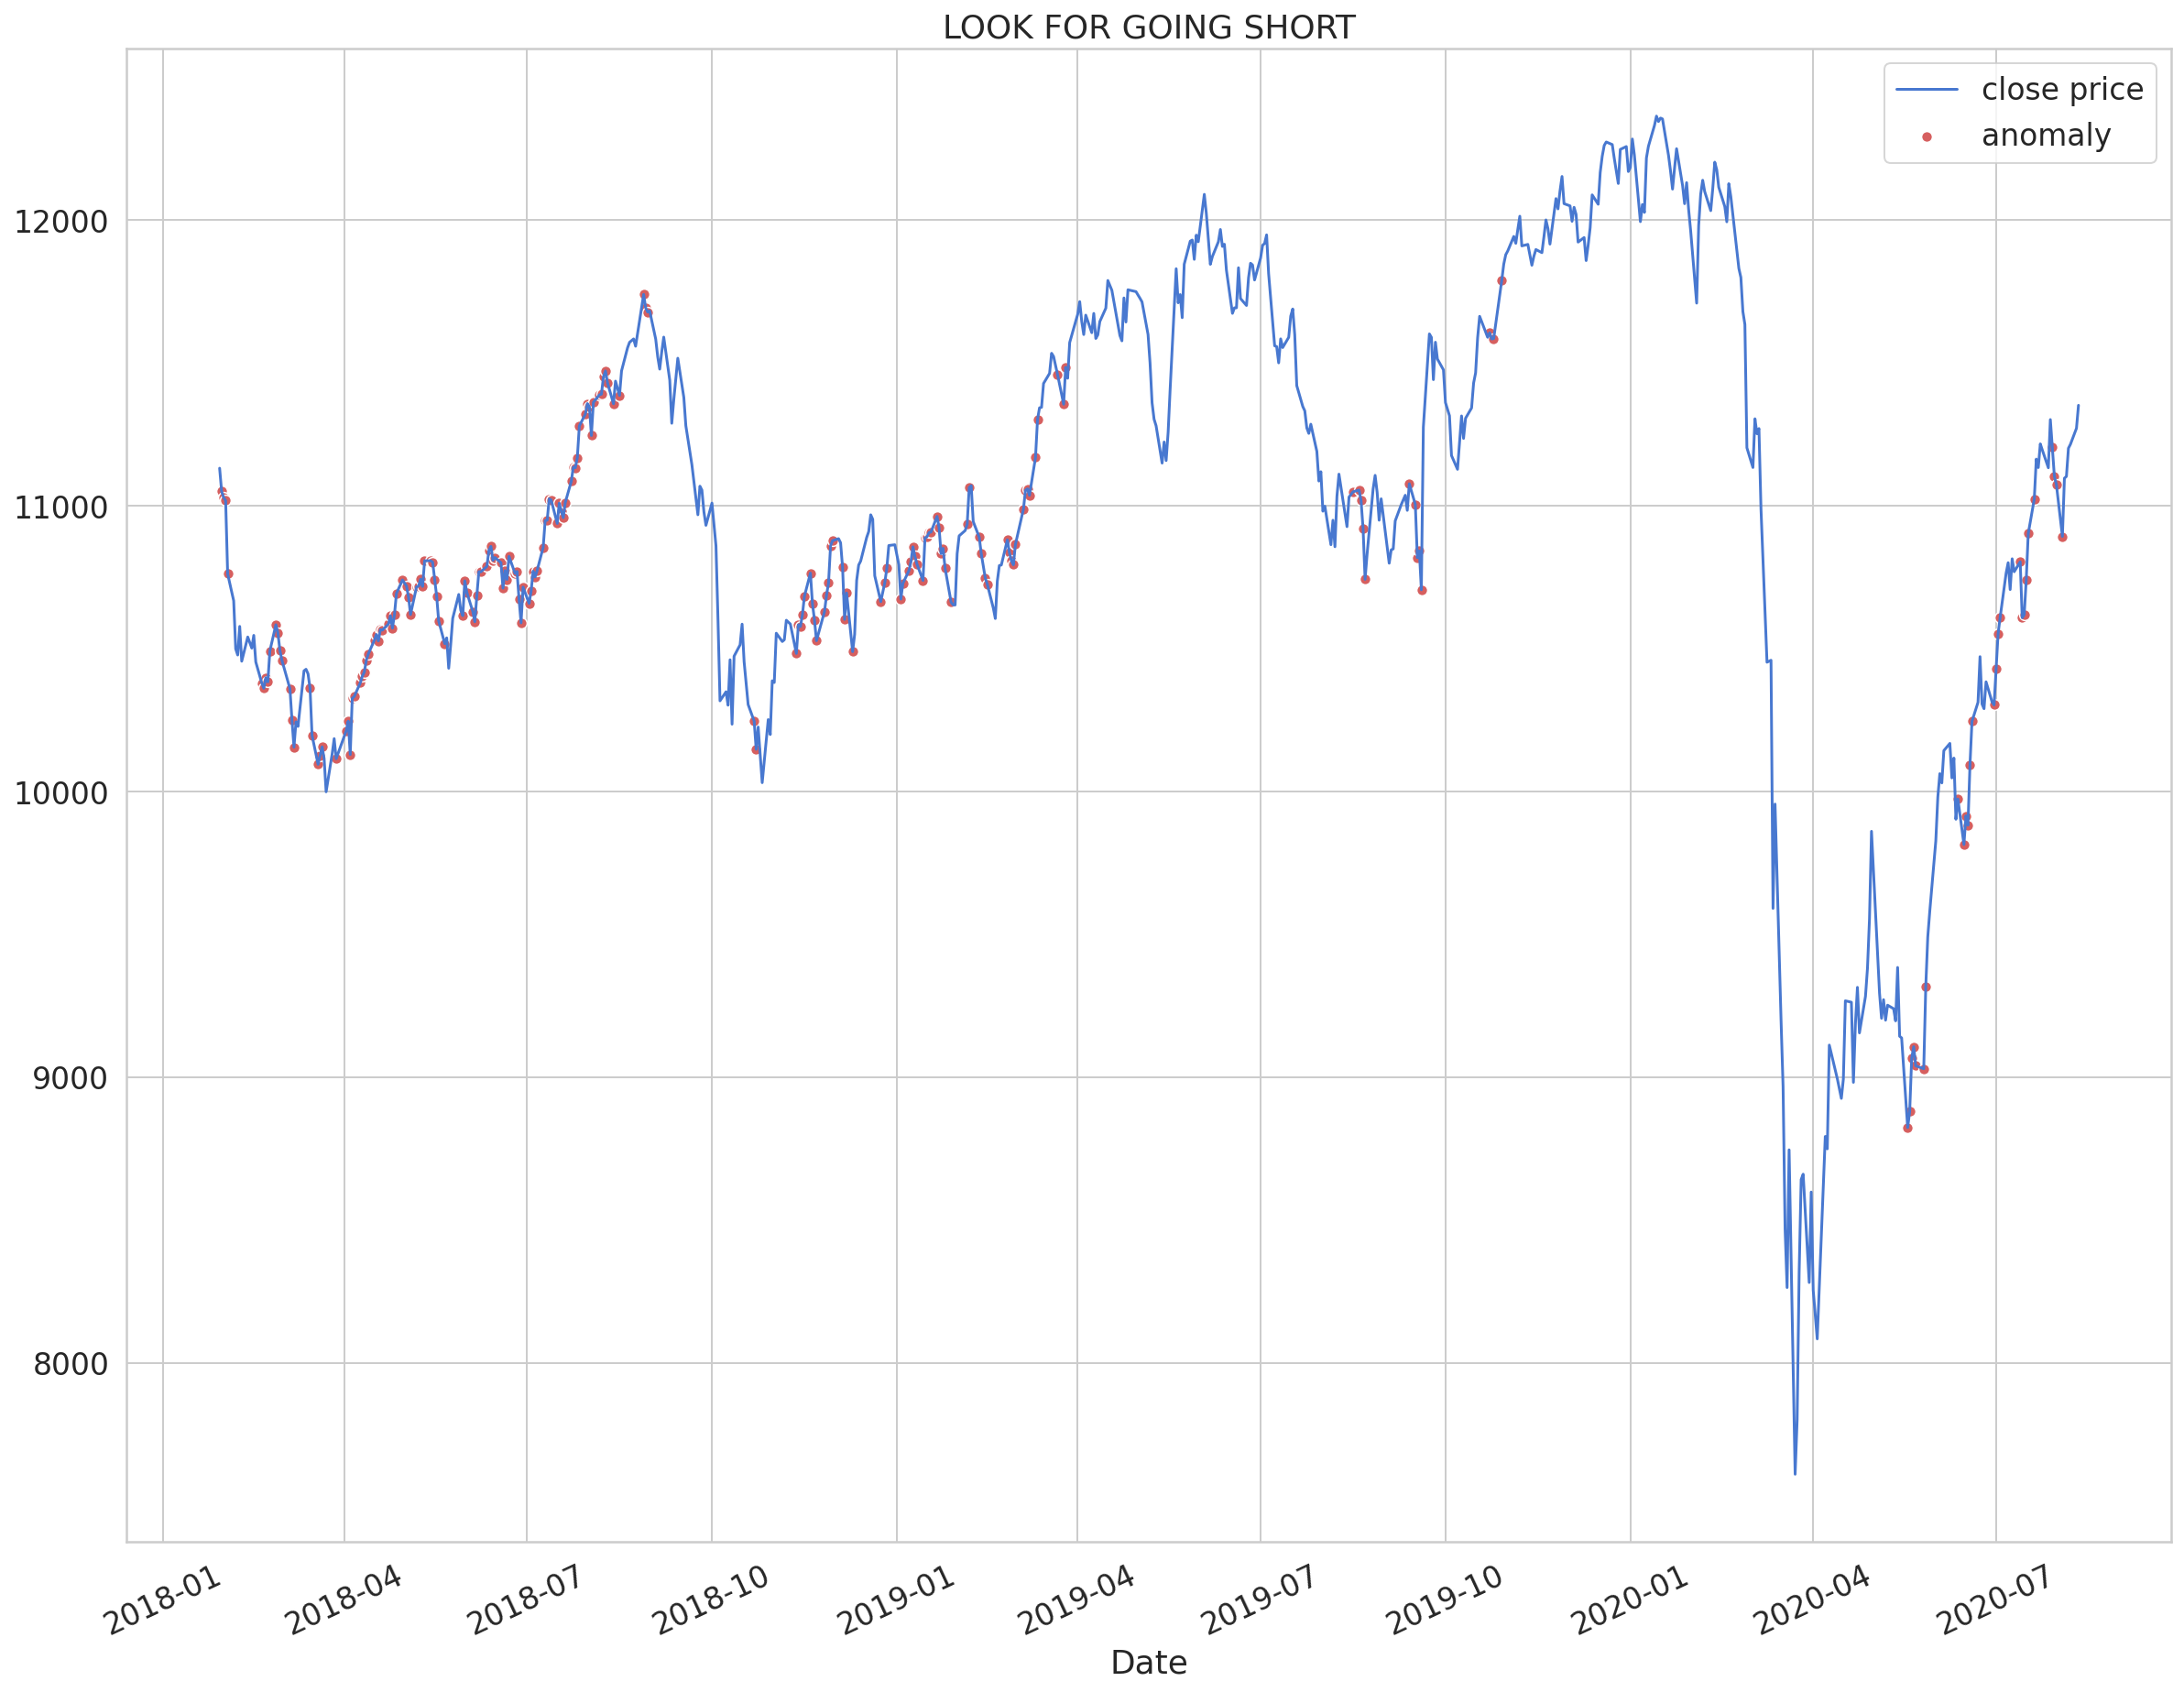

In [ ]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].Close), 
  label='close price'
);

sns.scatterplot(
  anomaliesS.index,
  scaler.inverse_transform(anomaliesS.Close),
  color=sns.color_palette()[3],
  s=35,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.savefig('anamolySHORT.png', dpi=150)
plt.title('LOOK FOR GOING SHORT')
plt.legend();